<a href="https://colab.research.google.com/github/mayur7garg/66DaysOfData/blob/main/Day%2019/Hierarchical_Agglomerative_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical Agglomerative Clustering

**References:**
- [HAC: Hierarchical Agglomerative Clustering — Is It Better Than K-Means?](https://towardsdatascience.com/hac-hierarchical-agglomerative-clustering-is-it-better-than-k-means-4ff6f459e390)
- [Hierarchical Agglomerative Clustering Algorithm Example In Python](https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019)

## Types of Linkage in HAC:
- **Single:** The distance between two clusters is the shortest distance between two points in each cluster
- **Complete:** The distance between two clusters is the longest distance between two points in each cluster
- **Average:** The distance between clusters is the average distance between each point in one cluster to every point in other cluster
- **Ward:** The distance between clusters is the sum of squared differences within all clusters

## Imports

In [1]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import pandas as pd
from geopy.geocoders import Nominatim
from progressbar import ProgressBar
import time

## Set Plotly rendering to colab

In [2]:
import plotly.io as pio
pio.renderers.default = 'colab'

## Loading Data
Dataset used is available on Kaggle at [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)

In [3]:
pd.options.display.max_columns=50

df = pd.read_csv('/content/weatherAUS.csv', encoding = 'utf-8')

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Data preprocessing
- Remove values where `RainTomorrow` is null.
- Impute missing values with mean.
- Extract the location info `Location` column such that it can be used by `geopy` API.

In [4]:
df = df[pd.isnull(df['RainTomorrow']) == False]
df = df.fillna(df.mean())
df['Location2'] = df['Location'].str.replace(r"([A-Z])", r" \1").str.strip()
df['Location2'] = df['Location2'].apply(lambda x: 'Pearce, Bullsbrook' if x == 'Pearce R A A F' else x)

df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Location2
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No,Albury
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No,Albury
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No,Albury
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No,Albury
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,Albury


## Extract the longitudes and latitudes for the locations 
Each call is delayed by a small duration to avoid overloading the server.

In [5]:
loc_list = list(df.Location2.unique())

geolocator = Nominatim(user_agent = "66DaysOfDataByMayur")
country ="Australia"
loc_res = []

pbar = ProgressBar()
for city in pbar(loc_list):
    loc = geolocator.geocode(city + ',' + country)
    res = [city, loc.latitude, loc.longitude]
    loc_res = loc_res + [res]
    time.sleep(0.5) 

df_loc = pd.DataFrame(loc_res, columns = ['Loc', 'Latitude', 'Longitude'])

df_loc.head()

100% (49 of 49) |########################| Elapsed Time: 0:00:37 Time:  0:00:37


,Loc,Latitude,Longitude
0,Albury,-36.080477,146.916280
1,Badgerys Creek,-33.881667,150.744163
2,Cobar,-31.498333,145.834444
3,Coffs Harbour,-30.296241,153.113529
4,Moree,-29.461720,149.840715


## Create a `Scattergeo` plot using `Plotly` centerd on Australia with all the locations marked

In [6]:
fig = go.Figure(data = go.Scattergeo(
        lat = df_loc['Latitude'],
        lon = df_loc['Longitude'],
        hovertext = df_loc['Loc'], 
        mode = 'markers',
        marker_color = 'black'
        ))

fig.update_layout(
        width = 980,
        height = 720,
        title = 'Locations in Australia',
        margin = {"r":0, "t":50, "l":0, "b":10},
        geo = dict(
            scope = 'world',
            projection_type='miller',
            landcolor = "rgb(250, 250, 250)",
            center = dict(lat = -25.69839, lon = 139.8813),
            projection_scale = 6 # zoom in on
        ),
    )
fig.show()

### HAC Dendograms

### HAC Dendogram using Average method

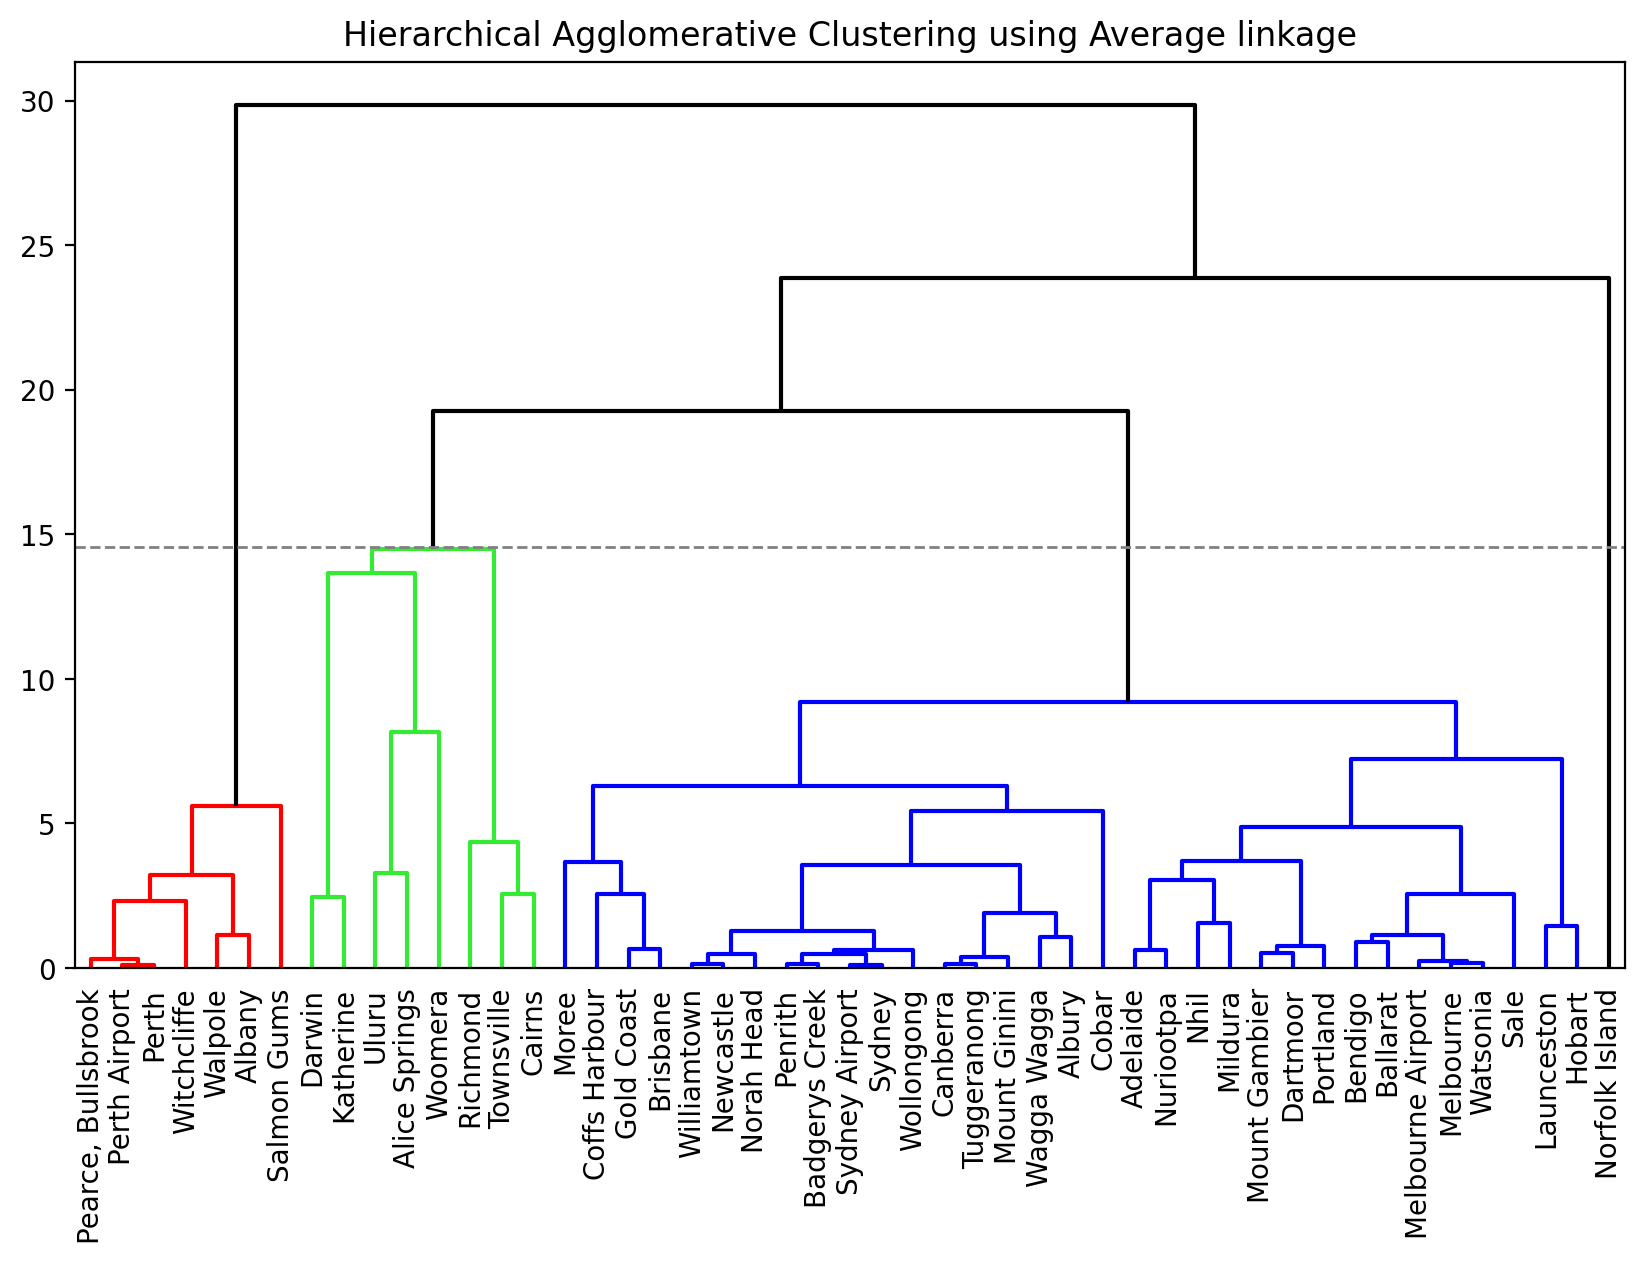

In [7]:
X = df_loc[['Latitude', 'Longitude']]

plt.figure(figsize = (10, 6), dpi = 200)

Z = sch.linkage(X, method = 'average', optimal_ordering = True)

sch.set_link_color_palette(['red', '#34eb34', 'blue', '#ae34eb'])

sch.dendrogram(Z, leaf_rotation = 90, leaf_font_size = 10, labels = list(df_loc['Loc']), 
               color_threshold = 14.55, above_threshold_color = 'black')
 
plt.axhline(y = 14.55, c = 'grey', lw = 1, linestyle = 'dashed')
plt.title('Hierarchical Agglomerative Clustering using Average linkage')
plt.show()

### HAC Dendogram using Ward method

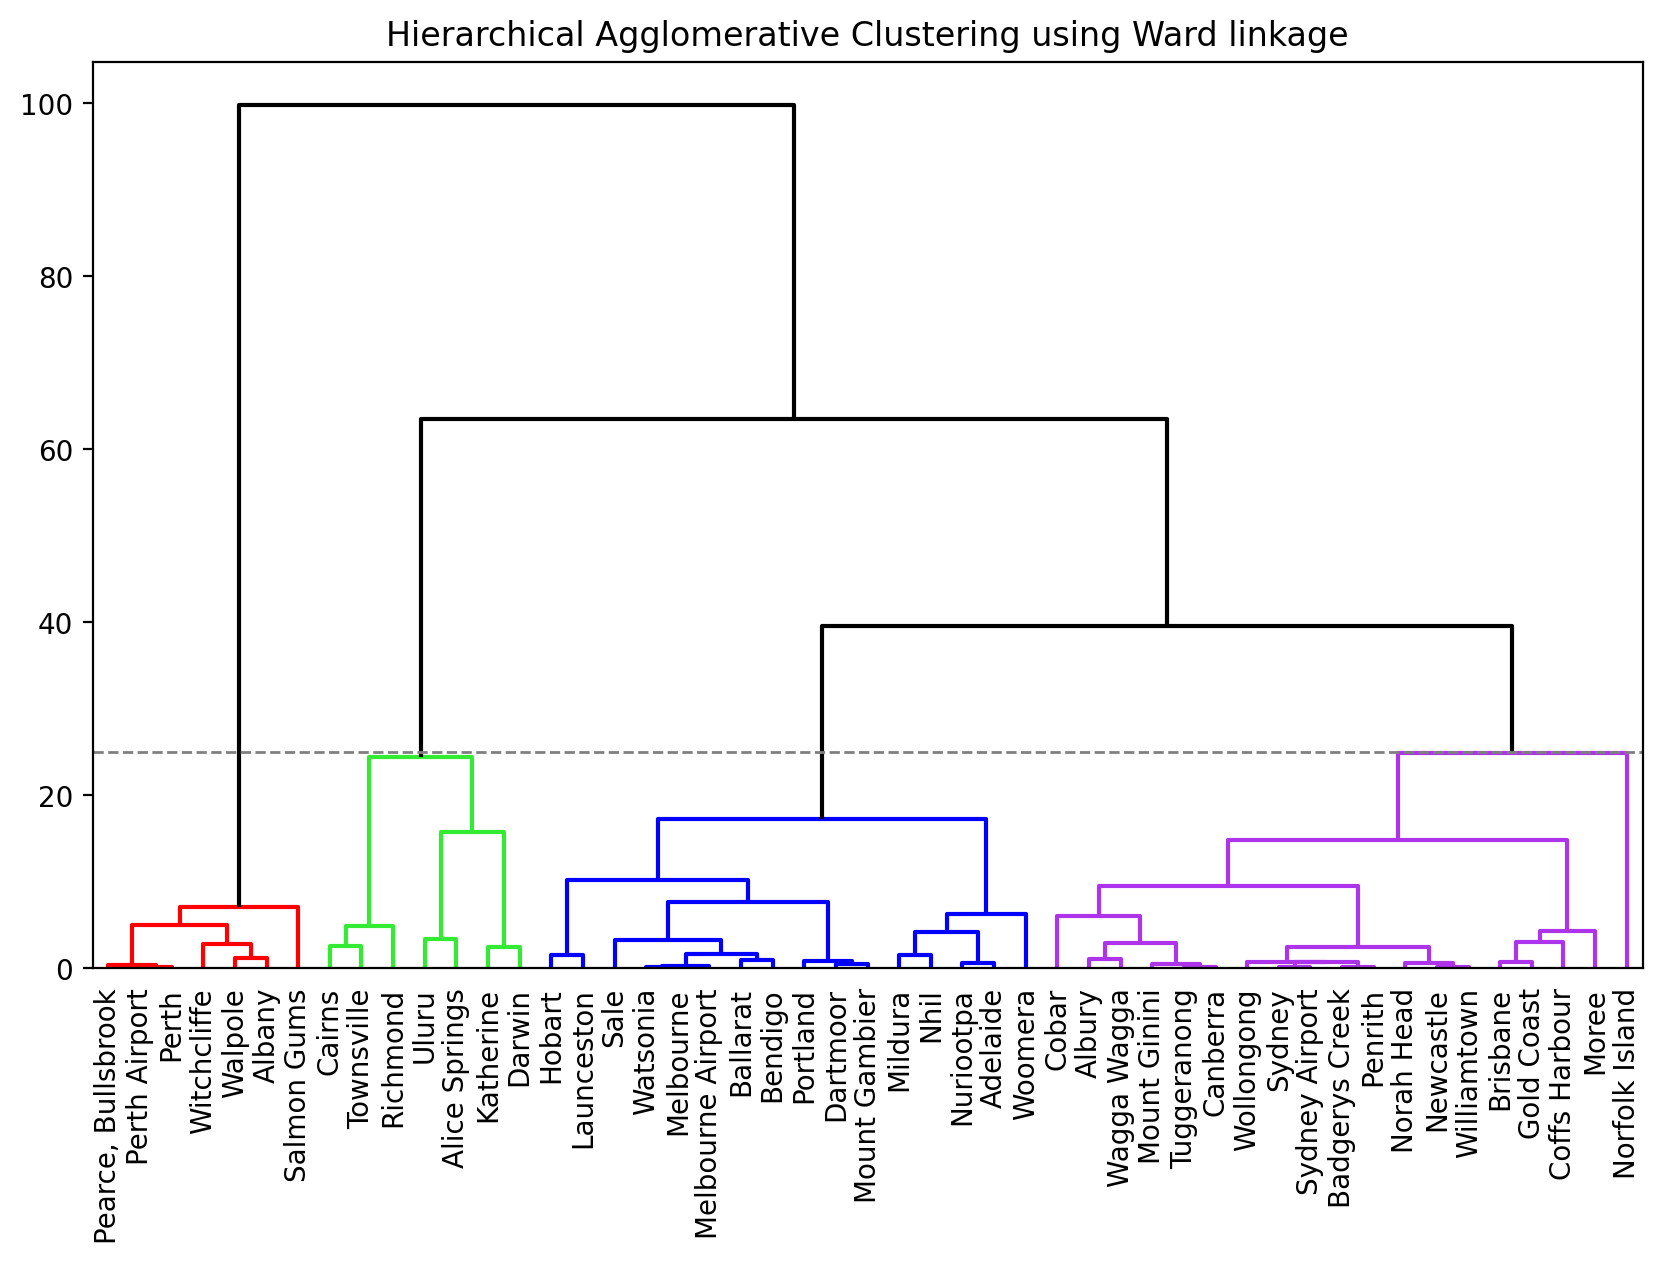

In [8]:
X = df_loc[['Latitude', 'Longitude']]

plt.figure(figsize = (10, 6), dpi = 200)

Z = sch.linkage(X, method = 'ward', optimal_ordering = True)

sch.set_link_color_palette(['red', '#34eb34', 'blue', '#ae34eb'])

sch.dendrogram(Z, leaf_rotation = 90, leaf_font_size = 10, labels = list(df_loc['Loc']), 
               color_threshold = 25, above_threshold_color = 'black')
 
plt.axhline(y = 25, c = 'grey', lw = 1, linestyle = 'dashed')
plt.title('Hierarchical Agglomerative Clustering using Ward linkage')
plt.show()

## HAC using sklearn

### `AgglomerativeClustering` using Average and ward methods with 4 clusters

In [9]:
modela4 = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'average')
modelw4 = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')

clusta4 = modela4.fit(X)
clustw4 = modelw4.fit(X)

df_loc['Clusta4'] = clusta4.labels_
df_loc['Clustw4'] = clustw4.labels_

df_loc.sample(10)

,Loc,Latitude,Longitude,Clusta4,Clustw4
45,Alice Springs,-23.698388,133.881289,0,2
9,Richmond,-20.569655,142.928360,0,2
27,Dartmoor,-37.922544,141.276655,1,1
22,Melbourne,-37.814218,144.963161,1,1
0,Albury,-36.080477,146.916280,1,0
2,Cobar,-31.498333,145.834444,1,0
35,Woomera,-31.199914,136.825353,0,1
44,Launceston,-41.434081,147.137350,1,1
34,Nuriootpa,-34.469335,138.993901,1,1
43,Hobart,-42.882509,147.328123,1,1


### `Scattergeo` plot with Average HAC

In [10]:
fig = go.Figure(data = go.Scattergeo(
        lat = df_loc['Latitude'],
        lon = df_loc['Longitude'],
        hovertext = df_loc[['Loc', 'Clusta4']], 
        mode = 'markers',
        marker = dict(colorscale = ['#34eb34', 'blue', '#ae34eb', 'red']),
        marker_color = df_loc['Clusta4'],
        ))

fig.update_layout(
        showlegend = False,
        width = 980,
        height = 720,
        title = 'HAC using Average Linkage',
        margin = {"r":0, "t":50, "l":0, "b":10},
        geo = dict(
            scope = 'world',
            projection_type = 'miller',
            landcolor = "rgb(250, 250, 250)",
            center = dict(lat = -25.69839, lon = 139.8813),
            projection_scale = 6
        ),
    )
fig.show()

### `Scattergeo` plot with Ward HAC

In [11]:
fig = go.Figure(data = go.Scattergeo(
        lat = df_loc['Latitude'],
        lon = df_loc['Longitude'],
        hovertext = df_loc[['Loc', 'Clustw4']], 
        mode = 'markers',
        marker = dict(colorscale = ['#34eb34', 'blue', '#ae34eb', 'red']),
        marker_color = df_loc['Clustw4'],
        ))

fig.update_layout(
        showlegend = False,
        width = 980,
        height = 720,
        title = 'HAC using Ward Linkage',
        margin = {"r":0, "t":50, "l":0, "b":10},
        geo = dict(
            scope = 'world',
            projection_type = 'miller',
            landcolor = "rgb(250, 250, 250)",
            center = dict(lat = -25.69839, lon = 139.8813),
            projection_scale = 6
        ),
    )
fig.show()